# 따릉이 데이터 시각화

## Hypothesis

1. 공유킥보드 규제 정책에 따라 따릉이 사용량이 영향 받을 것이다.
2. 비가 오지 않는 날은 비가 오는 날보다 사용량이 더 많을 것이다.
3. 주말의 경우, 일일권의 사용량이 더 많을 것이며, 평일의 경우 정기권의 사용량이 더 많을 것이다.
4. 서울 지역 위치가 외곽일수록 평균 사용시간이 늘어날 것이다.
    - 4-2. 대여소 수가 적을수록 평균 사용시간이 늘어날 것이다.
5. 대여소 위치에 따라 주되게 사용하는 연령대가 존재할 것이다.
    - 학교 주변은 10~20대가 가장 주되게 사용할 것
    - 공원 주변은 30~40대가 가장 주되게 사용할 것

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests, json
import folium

import warnings
warnings.filterwarnings(action='ignore')
plt.rc("font", family="AppleGothic")

## 데이터 - 따릉이 대여 정보

기간 : 2017.01.01 ~ 2022.06.08

- 대여일자 : 일자
- 대여시각 : 총 따릉이 대여시각
- 대여소번호 : 대여 장소 코드 번호
- 대여소 : 따릉이를 대여한 장소
- 대여구분코드 : 대여권
- 성별 : 사용자의 성별
- 연령대 코드 : 사용자의 연령대
- 운동량 : 사용자의 운동량
- 이동거리(M) : 따릉이로 이동한 거리
- 사용시간(분) : 실제 따릉이 사용시간

In [2]:
df = pd.read_csv('./data/bicycle_data.csv')

df.drop("index", axis=1, inplace = True)
df = df.astype({'대여일자' : 'datetime64[ns]'})
df.set_index('대여일자', drop = True, inplace = True)

df.head()

대여시간  대여소번호 대여구분코드 성별 연령대코드     운동량    이동거리               대여소  \
대여일자                                                                        
2017-01-01     0    230    정기권  F  ~10대   31.27  1680.0    ' 영등포구청역 1번출구'   
2017-01-01     0    900    정기권  M  ~10대  135.16  3670.0         ' 은평예술회관'   
2017-01-01    15    402    정기권  M   40대   74.69  2300.0  ' 상암월드컵파크 9단지 앞'   
2017-01-01     0    328    정기권  F   20대   57.92  2250.0         ' 탑골공원 앞'   
2017-01-01     0    175    정기권  F   20대  133.29  6600.0          ' 홍연2교옆'   

             사용시간  
대여일자               
2017-01-01  155.0  
2017-01-01   19.0  
2017-01-01   54.0  
2017-01-01   13.0  
2017-01-01   43.0

## 1. 공유킥보드 규제 정책에 따라 따릉이 사용량이 영향 받을 것이다.

- 공유킥보드와 따릉이 모두 자유롭게 대여 가능한 개인형 이동수단
    - 개인형 이동수단의 사용자는 한정적!
    - 결국 전체 사용량을 함께 공유한다고 볼 수 있음
- 즉, 공유킥보드의 규제가 변함에 따라 공유킥보드 사용량에 영향 미칠 뿐만 아니라, 자연스레 공통된 개인형 이동수단인 따릉이 또한 사용량에 영향이 있을 것이라 유추
    - 공유킥보드 등장 (2019년 7월) -> 공유킥보드 규제 (2020년 1월) -> 공유킥보드 규제 완화 (2020년 12월) -> 공유킥보드 규제 (2021년 5월)

In [3]:
# 월별 따릉이 사용량
usage = df.resample(rule='1M').count()

# 공유킥보드 규제 정책 날짜
kickboard_regulation = ['2019-07', '2020-01', '2020-12', '2021-05']
end = lambda x : str(np.datetime64(x) + 2)

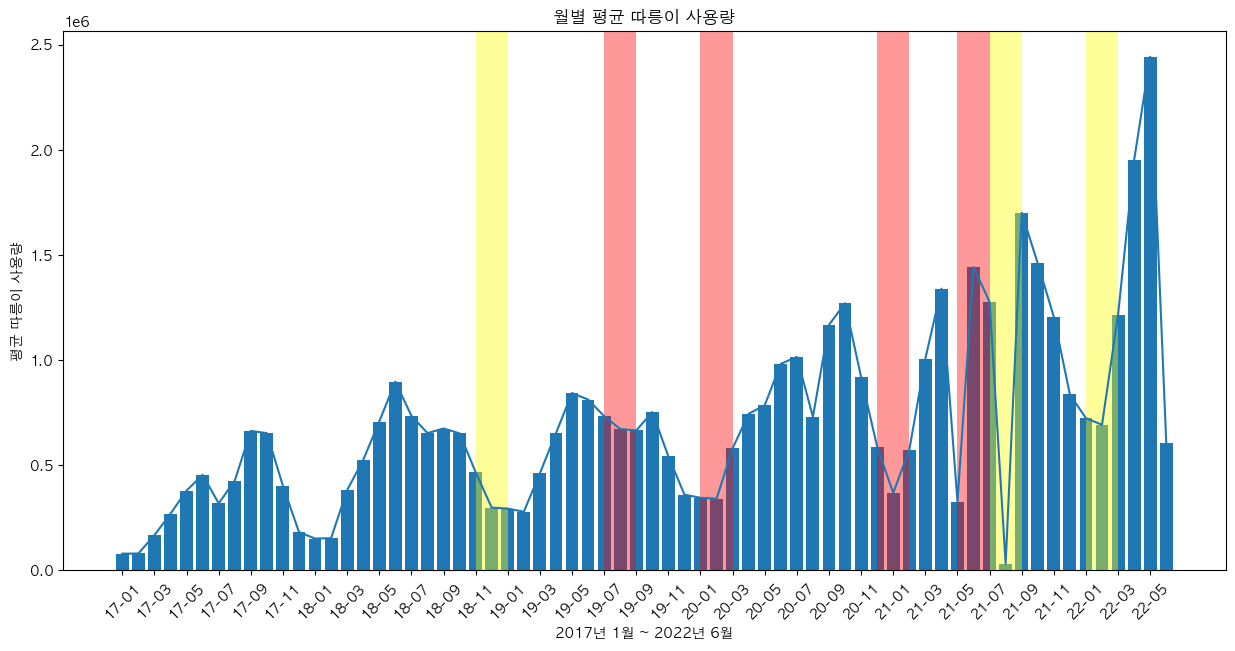

In [4]:
fig = plt.figure()
ax = plt.gca()
fig.set_size_inches(15, 7)

ax.xaxis.set_ticks([])

plt.title('월별 평균 따릉이 사용량')
plt.ylabel('평균 따릉이 사용량')
plt.xlabel('2017년 1월 ~ 2022년 6월')

xs      = usage.index.strftime("%Y-%m")
xlabels = usage.index.strftime("%Y-%m").map(lambda x: x[2:])

plt.bar(xs, usage['대여시간'])
plt.plot(xs, usage['대여시간'])

plt.xticks(ticks=xs, labels=xlabels, rotation=45)
plt.locator_params(axis='x', nbins=len(xlabels)/2)

for i in range(len(kickboard_regulation)):
    end_li = list(map(end, kickboard_regulation))
    plt.axvspan(kickboard_regulation[i],end_li[i], facecolor = 'red', alpha = 0.4)

extreme = ['2021-07', '2018-11', '2022-01']
    
for i in range(len(extreme)):
    end_li = list(map(end, extreme))
    plt.axvspan(extreme[i],end_li[i], facecolor = 'yellow', alpha = 0.4)

plt.show()

기존 가설 : 공유킥보드 등장 (2019년 7월) -> 공유킥보드 규제 (2020년 1월) -> 공유킥보드 규제 완화 (2020년 12월) -> 공유킥보드 규제 (2021년 5월)
   - 실제적으로 19년 7월 이후, 따릉이의 사용량이 점차 줄어드는 추세를 보이다가 규제 (2020년 1월) 이후 급증하는 모습을 볼 수 있다.
   - 이후, 2020년 12월 규제 완화와 2021년 5월 규제는 따릉이에 별 영향을 주지 않음을 보인다.
    
그 외에 급격하게 감소한 18년 11월, 21년 7월, 22년 1월을 살펴봄
   - 2017~2018년 초의 경우, 대여소 설치가 이루어지는 시기이기 때문에 제외함
   - 2018년 11월의 경우, 따릉이 헬멧 의무화 규제가 실행되는 시점임으로 밝혀짐
   - 2021년 7월, 2022년 1월은 따로 어떠한 규제나 이슈 발견 X
   - https://namu.wiki/w/%EB%94%B0%EB%A6%89%EC%9D%B4/%EC%97%AD%EC%82%AC#s-8

즉, 공통적으로 개인형 이동수단이었던 공유킥보드의 규제로 따릉이의 사용량에 영향을 어느정도 준다고 말할 수 있다.
- 다만, 이외에도 따릉이 자체적인 규제, 사회적 분위기 등 다른 부가적인 요소에 따라서도 충분히 영향 받을 수 있음 

## 2. 비가 오지 않는 날은 비가 오는 날보다 사용량이 더 많을 것

## 데이터 - 서울 지역의 강수량 데이터
기간 : 2017/01/01 ~ 2022/06/30

- 강수량 (mm) : 해당 기간동안의 일별 강수량 (mm)
- 비 여부 col 추가
    - 비가 올 경우 (1) / 오지 않을 경우 (0)
    - 강수량이 0보다 클 경우, 비가 온 것으로 간주

In [5]:
rain = pd.read_csv('./data/서울시 강수량 정보.csv', encoding='cp949', skiprows=7).fillna(0)
rain = rain.astype({'날짜' : 'datetime64[ns]'})
rain.set_index('날짜', drop = True, inplace = True)

# 비 여부 col 추가
rain['rainToday'] = rain['강수량(mm)'].apply(lambda x: 1 if x > 0.0  else 0)
rain.drop(['지점'], axis=1, inplace = True)

rain.head()

강수량(mm)  rainToday
날짜                            
2017-01-01      0.0          0
2017-01-02      0.3          1
2017-01-03      0.0          0
2017-01-04      0.0          0
2017-01-05      0.0          0

### 비 여부에 따른 일별 따릉이 평균 사용량 (년도별)

In [6]:
# df_rain : 기존 데이터와 병합한 데이터프레임
df_rain = pd.merge(df, rain, left_index=True, right_index=True)

# rain_usage : 일별 따릉이 총 사용량 데이터프레임
rain_usage = pd.DataFrame(rain['rainToday'])

# 일별 따릉이 사용량
rain_usage['bicycle_usage'] = df_rain['rainToday'].resample(rule='1D').count()

rain_usage.head()

rainToday  bicycle_usage
날짜                                  
2017-01-01          0           2167
2017-01-02          1           3488
2017-01-03          0           3683
2017-01-04          0           4219
2017-01-05          0           4109

### 비 여부에 따른 평균 따릉이 사용량 (년도별)

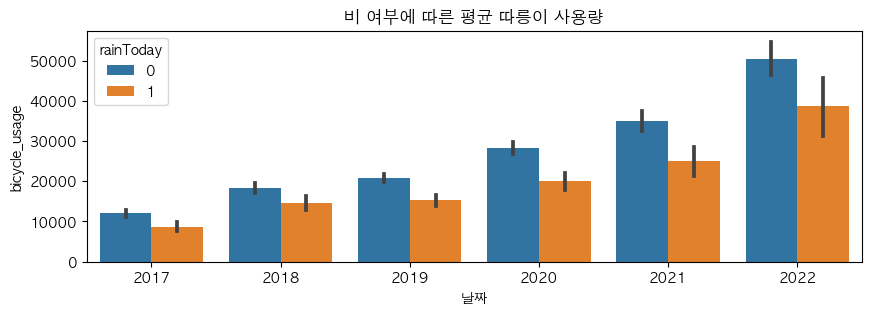

In [7]:
fig = plt.figure()
fig.set_size_inches(10, 3)

plt.title('비 여부에 따른 평균 따릉이 사용량')
plt.ylabel('평균 따릉이 사용량')
# plt.legend(labels=("rain","not rain"))

sns.barplot(x = rain_usage.index.year, y='bicycle_usage', hue="rainToday", data = rain_usage, estimator=np.mean)
plt.show()

- 그래프를 보았을 때, 오지 않은 날이 비가 온 날보다 사용량이 높음을 확인

- 2017년도 -> 2022년도로 흐르면서 전체적인 자전거 사용량이 급증함에 비해 비가 온 날과 오지 않은 날의 사용량 비율은 비슷하다고 생각
- 또한, 예상보다 다소 차이나지 않는 평균 사용량
    - 비가 오는 날에 따릉이를 이용하는 사용자들의 명확한 사유가 존재할 것 (일시적인 현상이 아니다)

### 강수량에 따른 평균 사용량 및 평균 사용시간

- 강수량이 0보다 클 경우, 모두 비가 온다고 가정했기 때문에 사실상 비가 약하게 올 경우도 모두 포함되었을 것
    - 오히려 비를 피하기 위해 따릉이를 이용할 수도 있다고 생각

In [8]:
# precipitation_df : 날짜에 따른 강수량과 총 따릉이 사용량, 평균 사용시간 데이터프레임
precipitation_df = rain_usage
precipitation_df['강수량(mm)'] = rain['강수량(mm)']
precipitation_df['사용시간(분)'] = df_rain['사용시간'].resample(rule='1D').mean()

# bicycle_usage_by_precipitation : 강수량에 따른 평균 따릉이 사용량과 평균 사용시간
bicycle_usage_by_precipitation = precipitation_df.groupby('강수량(mm)').mean()

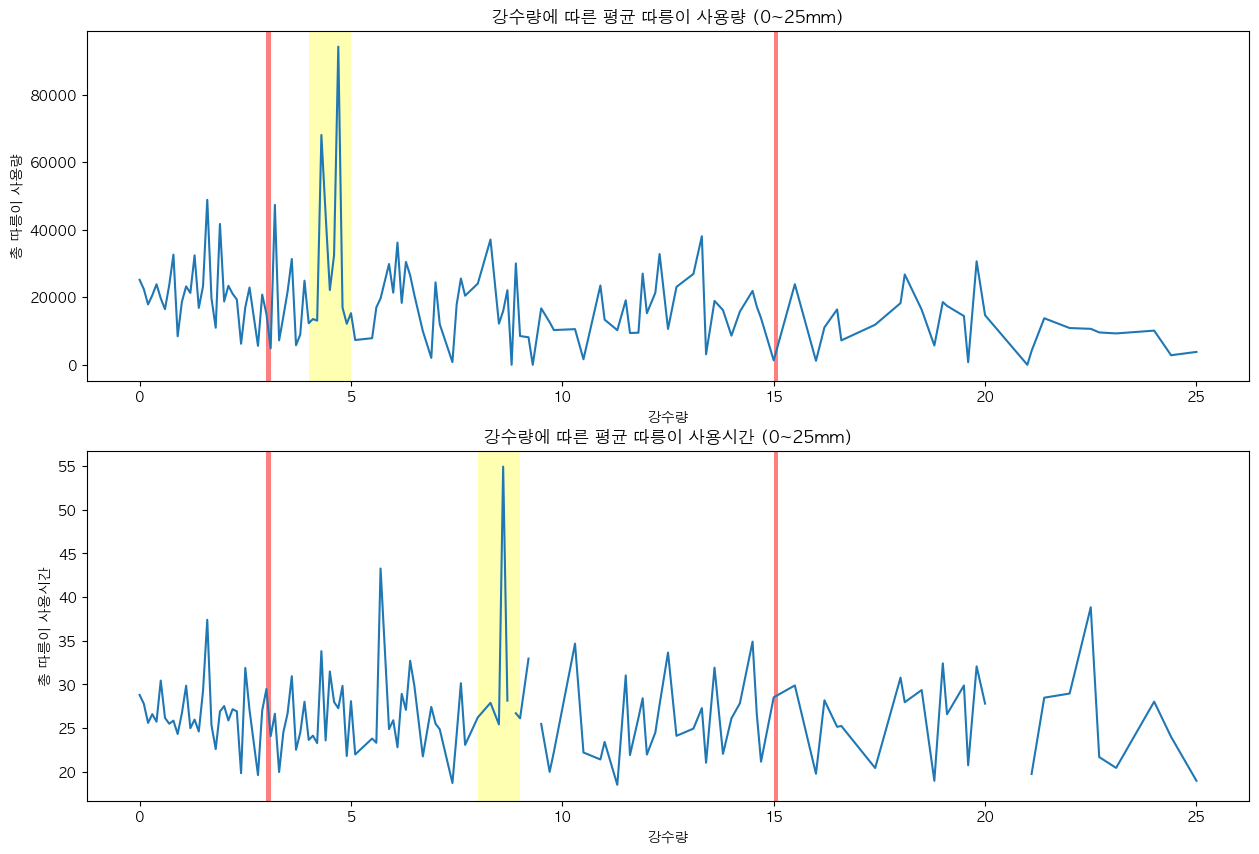

In [9]:
fig = plt.figure()
fig.set_size_inches(15,10)

ax_1 = fig.add_subplot(2,1,1)
ax_2 = fig.add_subplot(2,1,2)

ax_1.set_title('강수량에 따른 평균 따릉이 사용량 (0~25mm)')
ax_1.set_ylabel('총 따릉이 사용량')
ax_1.set_xlabel('강수량')

ax_2.set_title('강수량에 따른 평균 따릉이 사용시간 (0~25mm)')
ax_2.set_ylabel('총 따릉이 사용시간')
ax_2.set_xlabel('강수량')

ax_1.plot(bicycle_usage_by_precipitation.loc[:25].index, bicycle_usage_by_precipitation.loc[:25]['bicycle_usage'])
ax_1.axvspan(3,3.1, facecolor = 'red', alpha = 0.5)
ax_1.axvspan(4, 5, facecolor = 'yellow', alpha = 0.3)
ax_1.axvspan(15,15.1, facecolor = 'red', alpha = 0.5)

ax_2.plot(bicycle_usage_by_precipitation.loc[:25].index, bicycle_usage_by_precipitation.loc[:25]['사용시간(분)'])
ax_2.axvspan(3,3.1, facecolor = 'red', alpha = 0.5)
ax_2.axvspan(8, 9, facecolor = 'yellow', alpha = 0.3)
ax_2.axvspan(15,15.1, facecolor = 'red', alpha = 0.5)

plt.show()

- 보통 비는 1시간에 3~15mm 미만, 강한 비는 1시간에 15mm 이상 (https://m.blog.naver.com/kma_131/222073284939)
    - 0 ~ 3mm는 비가 오지 않음, 3 ~ 15mm는 약한 비, 15mm는 강한 비라고 가정했을 때, 오히려 약한 비일 경우, 따릉이 평균 사용량 및 평균 사용시간이 가장 큰 구간을 포함하고 있음
    - 이는 즉, 비가 오지 않는 날이 무조건적으로 따릉이의 사용량이 증가하는 것이 아닌, 비의 강세에 따라서 충분히 달라질 수 있음을 의미

## 3. 주말의 경우, 일일권의 사용량이 더 많을 것이며, 평일의 경우 정기권의 사용량이 더 많을 것이다.
- 단체권의 경우, 주말에 사용량이 가장 많을 것이다.

In [10]:
# date.weekday : {0 : 월, 1 : 화 ...}
day_of_week = {0: 'MON', 1: 'TUE', 2: 'WED', 3: 'THU', 4: 'FRI', 5: 'SAT', 6:'SUN'}

# weekday : 요일, 대여구분코드 데이터 프레임
week_df = pd.DataFrame(df[['대여구분코드', '사용시간']])
week_df['day_of_week'] = df.index.weekday.map(day_of_week)

# 대여구분코드 col 정리
week_df.loc[(week_df['대여구분코드'] == '일일(회원)') | (week_df['대여구분코드'] == '일일권(비회원)'), '대여구분코드'] = '일일권'

week_df.head()

대여구분코드   사용시간 day_of_week
대여일자                                
2017-01-01    정기권  155.0         SUN
2017-01-01    정기권   19.0         SUN
2017-01-01    정기권   54.0         SUN
2017-01-01    정기권   13.0         SUN
2017-01-01    정기권   43.0         SUN

### 요일별 대여구분코드 비율

In [11]:
weekend = (week_df['day_of_week'] == day_of_week[6]) | (week_df['day_of_week'] == day_of_week[5])

# temp_weekend : 주말 데이터프레임, temp_weekday : 평일 데이터프레임
temp_weekend = week_df[weekend]
temp_weekday = week_df[~weekend]

# 평일, 주말에 따른 대여구분코드별 총 개수
rental_ticket_weekend = temp_weekend.groupby(['대여구분코드']).count()['day_of_week'].sort_values()
rental_ticket_weekday = temp_weekday.groupby(['대여구분코드']).count()['day_of_week'].sort_values()

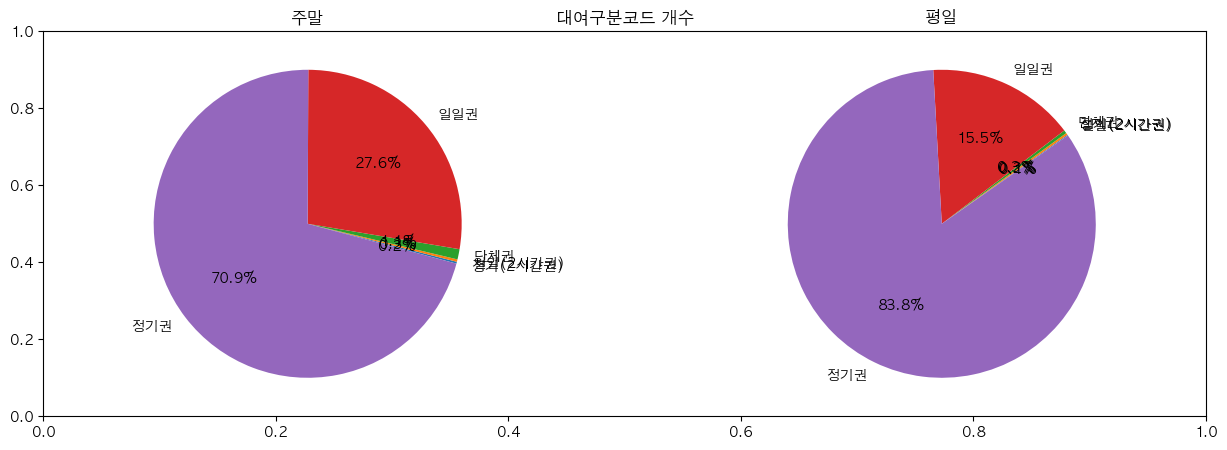

In [12]:
fig = plt.figure()
fig.set_size_inches(15,5)
fig.patch.set_visible(False)
plt.title('대여구분코드 개수')

ax_1 = fig.add_subplot(1,2,1)
ax_2 = fig.add_subplot(1,2,2)

ax_1.set_title('주말')
ax_2.set_title('평일')

ax_1.pie(rental_ticket_weekend, labels= rental_ticket_weekend.index, autopct='%.1f%%',startangle = -15)
ax_2.pie(rental_ticket_weekday, labels= rental_ticket_weekday.index, autopct='%.1f%%',startangle = 35)

plt.show()

- 주말과 평일 모두, 정기권의 대여구분코드 개수가 압도적인 것을 볼 수 있음
    - 정기권을 이용하는 사용자의 경우, 짧은 거리에서 자주 사용하는 경우가 존재할 수 있음
    - 즉, 따릉이를 많이 탄다는 관점에서 봤을 때, 부적절할 수 있다 -> 사용시간으로도 살펴보기

### 대여구분코드별 평균 사용시간

In [13]:
# 대여구분코드별 평균 사용시간
rental_hr_weekend = temp_weekend.groupby(['대여구분코드']).mean()['사용시간'].sort_values()
rental_hr_weekday = temp_weekday.groupby(['대여구분코드']).mean()['사용시간'].sort_values()

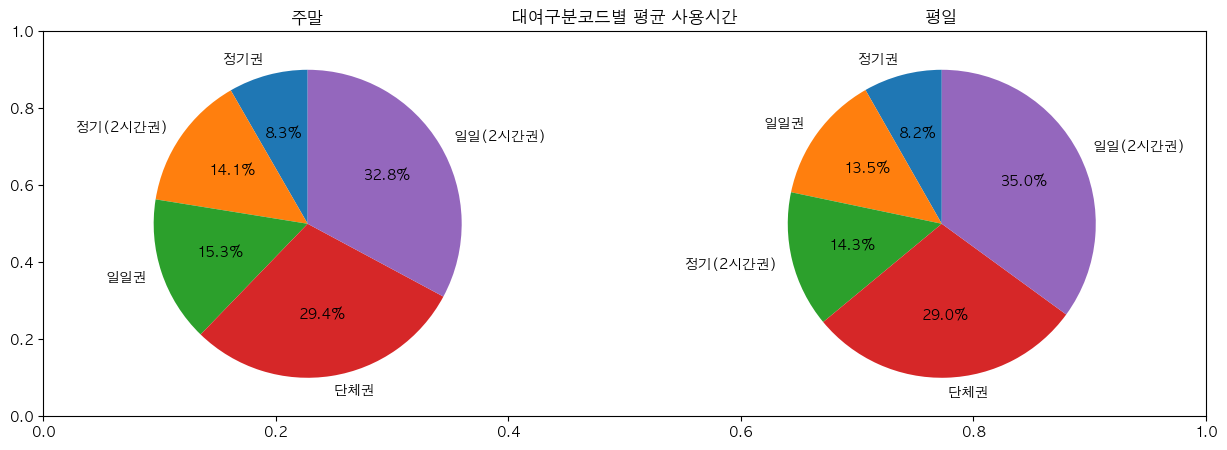

In [14]:
fig = plt.figure()
fig.set_size_inches(15,5)

plt.title('대여구분코드별 평균 사용시간')

ax_1 = fig.add_subplot(1,2,1)
ax_2 = fig.add_subplot(1,2,2)

ax_1.set_title('주말')
ax_2.set_title('평일')

ax_1.pie(rental_hr_weekend, labels= rental_hr_weekend.index, autopct='%.1f%%', startangle = 90)
ax_2.pie(rental_hr_weekday, labels= rental_hr_weekday.index,autopct='%.1f%%', startangle = 90)

plt.show()

- 앞선 상황과 동일하게 주말과 평일에는 별 차이가 없음을 보임
- 그러나 앞선 상황과 대조되게 일일권의 사용시간이 증가함을 볼 수 있음
    - 즉, 주말과 평일에는 별 차이가 없으며 (가설 기각), 사용량의 경우는 정기권이, 사용시간의 경우는 일일권과 단체권이 많음을 볼 수 있음

## 4-1. 서울 지역 위치가 외곽일수록 평균 사용시간이 늘어날 것이다.
- 이와 반대로 가까울 경우, 낮을 것

In [15]:
columns = ['대여소번호', '대여소명', '자치구', '상세주소', '위도', '경도', '설치시기', '거치대수(LCD)', '거치대수(QR)', '운영방식']
rental_inf = pd.read_csv("./data/map/공공자전거 대여소 정보(22.06월 기준).csv", encoding = 'cp949', skiprows = 6, names = columns)
rental_inf.head()

대여소번호        대여소명  자치구                상세주소         위도          경도  \
0    103  망원역 2번출구 앞  마포구   서울특별시 마포구 월드컵로 79  37.554951  126.910835   
1    104  합정역 1번출구 앞  마포구    서울특별시 마포구 양화로 59  37.550629  126.914986   
2    105  합정역 5번출구 앞  마포구    서울특별시 마포구 양화로 48  37.550007  126.914825   
3    106  합정역 7번출구 앞  마포구     서울특별시 마포구 독막로 4  37.548645  126.912826   
4    107  신한은행 서교동지점  마포구  서울특별시 마포구 월드컵북로 35  37.557510  126.918503   

         설치시기  거치대수(LCD)  거치대수(QR) 운영방식  
0  2022-05-03        NaN      14.0   QR  
1  2022-05-12        NaN      13.0   QR  
2  2015-09-06        NaN       5.0   QR  
3  2022-05-12        NaN      12.0   QR  
4  2021-12-28        NaN       5.0   QR

In [16]:
# rental_df : 자치구, df 데이터프레임
temp = rental_inf[['대여소번호', '자치구']]
rental_df = pd.merge(df, temp, how='inner', on='대여소번호')

# rental_df_hrs : 자치구별 평균 사용시간 (1인 기준)
temp = rental_df.groupby(['자치구'])['사용시간'].mean()
rental_df_hrs = pd.DataFrame(temp)

In [17]:
rental_df_hrs['사용시간'].sort_values()

자치구
강서구     24.126926
종로구     24.338245
중랑구     25.796285
양천구     26.538148
중구      27.052389
동대문구    27.087829
노원구     27.198258
성북구     27.214663
강북구     27.431250
은평구     27.475969
강동구     27.587729
도봉구     28.070116
서대문구    28.905045
금천구     29.403235
구로구     29.718016
광진구     30.000577
송파구     30.203120
관악구     30.210866
영등포구    32.800018
마포구     32.916007
동작구     33.584779
성동구     33.662256
강남구     34.484560
서초구     34.601844
용산구     36.252970
Name: 사용시간, dtype: float64

In [18]:
geo_path = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo.json'
url = requests.get(geo_path)
text = url.text
geo_str = json.loads(text)

center = [37.541, 126.986]

m = folium.Map(
    location = [center[0], center[1]],
    zoom_start = 11.2,
    tiles = 'cartodbpositron'
)

folium.GeoJson(
    geo_str,
    style_function = lambda x: {'fillColor':'#00000000' ,
                                'color':'black',
                                'weight' :'1'}
).add_to(m)

In [19]:
m.choropleth(geo_data = geo_str,
               data = rental_df_hrs['사용시간'],
               columns = [rental_df_hrs.index, rental_df_hrs['사용시간']],
               fill_color = "YlGn",
               key_on = "feature.properties.name")
m

- 평균 사용시간 적은 순 : 강서구, 종로구, 중랑구, 양천구, 종구
- 평균 사용시간 큰 순 : 용산구, 서초구, 강남구, 성동구, 동작구

- 위치가 외곽이어도 평균 사용시간과는 관계가 없어보이는 경우가 존재
    - 대여소의 개수에 따라 대여소의 수가 많은 경우, 따릉이를 타는 시간이 짧아지므로 대여소 수에도 영향이 있을 것이라 유추

## 4-2. 대여소 수가 적을수록 평균 사용시간이 늘어날 것이다.

In [20]:
# 자치구에 따른 대여소번호 개수
rental_df_count = pd.DataFrame(rental_inf.groupby(['자치구'])['대여소번호'].count().sort_values())
rental_df_count.head(), rental_df_count.tail()

(     대여소번호
 자치구       
 강북구     58
 동작구     71
 도봉구     72
 금천구     74
 관악구     76,
       대여소번호
 자치구        
 서초구     141
 영등포구    146
 강남구     159
 강서구     184
 송파구     209)

In [21]:
center = [37.541, 126.986]

m = folium.Map(
    location = [center[0], center[1]],
    zoom_start = 11.2,
    tiles = 'cartodbpositron'
)

folium.GeoJson(
    geo_str,
    style_function = lambda x: {'fillColor':'#00000000' ,
                                'color':'black',
                                'weight' :'1'}
).add_to(m)

In [22]:
m.choropleth(geo_data = geo_str,
               data = rental_df_count['대여소번호'],
               columns = [rental_df_count.index, rental_df_count['대여소번호']],
               fill_color = "YlGn",
               key_on = "feature.properties.name")
m

- 대여소가 많은 순 : 송파구, 강서구, 강남구, 영등포구, 서초구
- 적은 순 : 강북구, 동작구, 도봉구, 금천구, 관악구

앞선 결과와 비교했을 경우,
- 평균 사용시간 적은 순 : 강서구, 종로구, 중랑구, 양천구, 종구
- 평균 사용시간 큰 순 : 용산구, 서초구, 강남구, 성동구, 동작구

## 5. 대여소 위치에 따라 주된 연령대가 존재할 것이다.
- 학교 주변은 10~20대가 가장 많을 것으로 추정
- 공원 주변은 30대, 40대가 많을 것으로 추정

### 사용량이 많은 자치구 선정

In [23]:
# rental_df : 기존 데이터와 대여소 정보 데이터 결합
rental_df = pd.merge(rental_inf, df, how='inner', on='대여소번호')

# amount_usage : 자치구 기준 따릉이 사용량
amount_usage = rental_df.groupby(['자치구']).count()

# 정렬
sort_amount_usage = amount_usage.sort_values('대여소번호', ascending = False)

<AxesSubplot: xlabel='자치구', ylabel='대여소번호'>

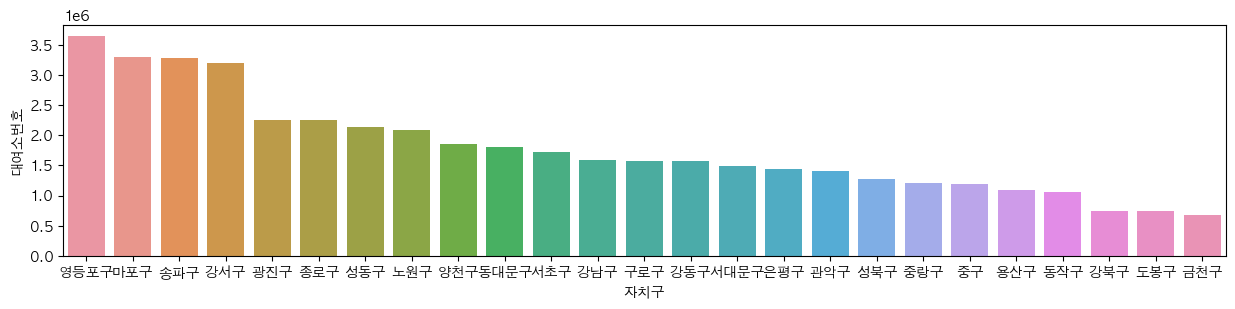

In [24]:
fig = plt.figure()
fig.set_size_inches(15, 3)

sns.barplot(x = sort_amount_usage.index, y = "대여소번호", data = sort_amount_usage)

- 가장 많은 사용량을 가진 자치구 : 영등포구

In [25]:
# Yeongdeungpo : 영등포구 대여소 정보 데이터프레임
Yeongdeungpo = rental_df[rental_df['자치구'] == '영등포구']

# temp : 연령대코드, 대여소번호별 따릉이 사용량
temp = Yeongdeungpo.groupby(['연령대코드', '대여소번호']).count()['대여시간']

age_list = np.sort(df['연령대코드'].unique().tolist())
top_rental_number = [0 for _ in range(len(age_list))]

# top_rental_number : 연령대별 따릉이 사용량순 대여소번호 10개
for i in range(len(age_list)):
    age = age_list[i]
    rental_code = temp.loc[age].sort_values().index
    top_rental_number[i] = rental_code[:10]

# age_rental : 연령대코드, 대여소 번호별 groupby
age_rental = Yeongdeungpo.groupby(['연령대코드', '대여소번호']).mean()

### 연령별 사용량 상위 10개 대여소

In [26]:
geo_path = './data/skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

# 영등포구 센터
center = [37.52006, 126.90308]

In [27]:
def map_maker(age):
    color = ['red', 'blue', 'green', 'yellow']
    
    map_ = folium.Map(
        location = [center[0], center[1]],
        zoom_start = 13.1,
        tiles = 'cartodbpositron'
    )

    folium.GeoJson(
        geo_str, name = '영등포구',
        style_function = lambda x: {'fillColor':'#00000000' ,
                                    'color':'black',
                                    'weight' :'1'}
    ).add_to(map_)
    
    for i in range(len(age)):
        ind = np.where(age_list == age[i])[0][0]

        for num in top_rental_number[ind]:
            temp = age_rental.loc[(age[i], num)]

            folium.Circle(
            location = [temp['위도'], temp['경도']], 
            popup = Yeongdeungpo.loc[Yeongdeungpo['대여소번호'] == num, '대여소명'][:1],
            color = color[i],
            radius= 200,
            fill = True
            ).add_to(map_)

    return map_

In [28]:
map_maker(['~10대'])

- 10대의 경우, 여의도 한강 공원을 위해 해당 주변의 대여소를 자주 이용함으로 추정

In [29]:
map_maker(['20대', '30대'])

In [30]:
map_maker(['40대', '50대'])

In [31]:
map_maker(['70대~'])